# Add various kinds of noise then test denoising methods

In [9]:
import cv2
import PIL
import numpy
import matplotlib
import os
import matplotlib.pyplot as plt

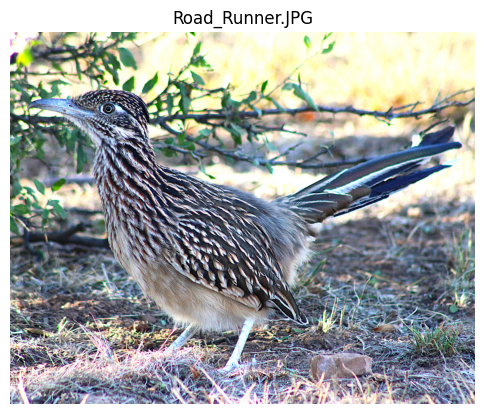

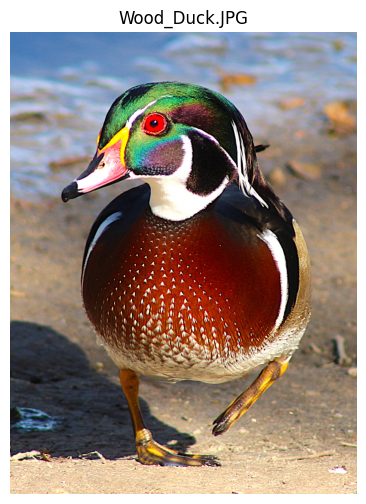

In [11]:
import matplotlib.pyplot as plt

image_folder = input("Image Folder Path: ")

# Supported image extensions
valid_ext = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')

if not os.path.isdir(image_folder):
    print("Invalid folder path.")
    exit(1)

# display all original images below
for image_name in sorted(os.listdir(image_folder)):
    if not image_name.lower().endswith(valid_ext):
        continue
    image_path = os.path.join(image_folder, image_name)
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_name}")
        continue
    # convert BGR (OpenCV) to RGB for correct colors in matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(image_name)
    plt.axis('off')
    plt.show()

In [ ]:
# Apply noise to images and display
for image_name in sorted(os.listdir(image_folder)):
    if not image_name.lower().endswith(valid_ext):
        continue
    image_path = os.path.join(image_folder, image_name)
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_name}")
        continue
    # convert BGR (OpenCV) to RGB for correct colors in matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Add Gaussian noise
    mean = 0
    sigma = 25
    gauss = numpy.random.normal(mean, sigma, img.shape).astype('uint8')
    noisy_img = cv2.add(img, gauss)
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Original: {image_name}")
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(noisy_img)
    plt.title(f"Noisy: {image_name}")
    plt.axis('off')
    
    plt.show()